In [16]:
import os
import sys
import gc

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

import warnings
import hydra

from hydra import compose, initialize
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_model, get_criterion
from src.data import MyDataset, load_data, transform_data

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

warnings.filterwarnings("ignore")
torch.manual_seed(42)

In [17]:
def get_weights(model):
    return [p.data for p in model.parameters()]

def get_random_weights(weights):
    return [torch.randn(w.size()).to(device) for w in weights]

def create_random_directions(model):
    x_direction = create_random_direction(model)
    y_direction = create_random_direction(model)

    return [x_direction, y_direction]

def create_random_direction(model):
    
    weights = get_weights(model)
    direction = get_random_weights(weights)
    normalize_directions_for_weights(direction, weights)

    return direction

def normalize_directions_for_weights(direction, weights):
    assert (len(direction) == len(weights))
    for d, w in zip(direction, weights):
        if d.dim() <= 1:
            d.fill_(0) 
        d.mul_(w.norm() / (d.norm() + 1e-10))
        
def set_weights(model, weights, directions, step):
    if len(directions) == 2:
        dx = directions[0]
        dy = directions[1]
        changes = [d0*step[0] + d1*step[1] for (d0, d1) in zip(dx, dy)]

    else:
        changes = [d*step for d in directions[0]]

    for (p, w, d) in zip(model.parameters(), weights, changes):
        p.data = w + d

def reset_weights(model, weights):
    for (p, w) in zip(model.parameters(), weights):
        p.data.copy_(w.type(type(p.data)))

In [18]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
CONFIG_NAME = "visualize_loss_config"
initialize(config_path='config/my_configs', version_base=None)
cfg = compose(config_name=CONFIG_NAME)
device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

In [19]:
# load data
print("Dataset", cfg["dataset"]["name"])
print("Model", cfg["model"]["name"])
print("Dataset", cfg["dataset"]['name'])

X_train, y_train, X_test, y_test = load_data(cfg["dataset"]['name'])

X_train, X_test, y_train, y_test = transform_data(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg["batch_size"], 
    shuffle=False
)

train_loader = DataLoader(
    MyDataset(X_train, y_train), 
    batch_size=cfg["batch_size"], 
    shuffle=False
)

dataset = MyDataset(X_test, y_test)
batch = dataset[10]
model_path = os.path.join(
    cfg["model_folder"],
    f"model_{cfg['model_id']}_{cfg['dataset']['name']}.pt",
)

model = get_model(
    cfg["model"]["name"],
    cfg["model"]["params"],
    path=model_path,
    device=device,
)

criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

Dataset FordA
Model AutoFormer
Dataset FordA


In [20]:
def compute_loss(model, train_loader, criterion, num_batches:int = 8):
    if criterion is None:
        criterion = F.cross_entropy

    loss = 0

    with torch.no_grad():
        for batch_idx, (Xb, Yb) in enumerate(train_loader):
            Xb, Yb = Xb.to(device), Yb.to(device)
    
            logits = model(Xb)
            loss += criterion(logits, Yb).item()

            if batch_idx + 1 >= num_batches:
                break
    
        loss = loss / (batch_idx + 1)
    return loss


100%|██████████| 25/25 [05:38<00:00, 13.55s/it]


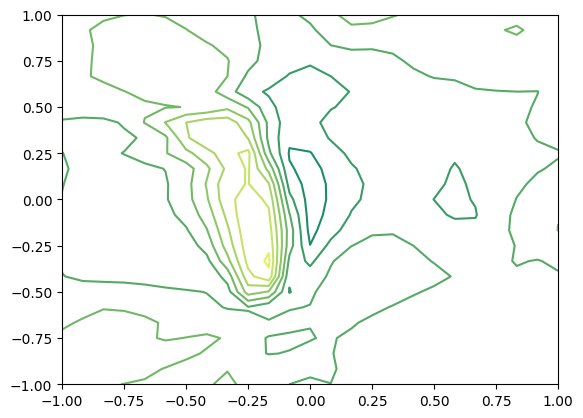

In [21]:
model.to(device)

directions = create_random_directions(model)

init_weights = [p.data for p in model.parameters()]

X, Y = np.meshgrid(np.linspace(-1, 1, 25), np.linspace(-1, 1, 25))
losses = np.empty_like(X)

total = X.shape[0] * X.shape[1]

for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        set_weights(model, init_weights, directions, np.array([X[i, j], Y[i, j]]))

        loss = compute_loss(model, train_loader, criterion, 3)
        losses[i, j] = loss

reset_weights(model, init_weights)

cp = plt.contour(X, Y, losses, cmap='summer')

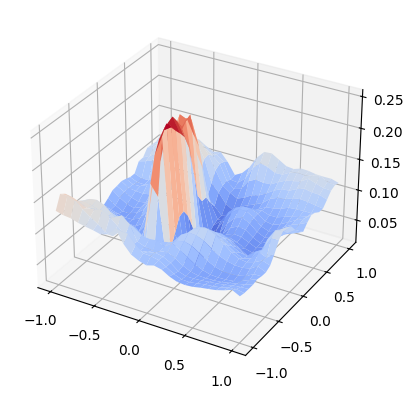

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, losses / 8, cmap=cm.coolwarm,)